In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np


2024-06-10 13:38:14.277843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 13:38:14.277940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 13:38:14.382595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define dataset directories
dataset_dir = '/kaggle/input/ishafolk/folk-art-dataset-main'


# Create directories for train, validation, and test splits
base_dir = 'folk-art-data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get class names

class_names = [c for c in sorted(os.listdir(dataset_dir)) if c != "README.md"]

for c in class_names:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(val_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)

In [4]:

def split_data(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if not os.path.isdir(category_path):  # Check if it's a directory
            continue
        images = os.listdir(category_path)
        train, temp = train_test_split(images, test_size=(1 - split_ratio[0]), random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

        for img in train:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category))
        for img in val:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category))
        for img in test:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category))

# Split the dataset
split_data(dataset_dir, train_dir, val_dir, test_dir)

In [5]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names  # Use the actual class names, excluding "readme"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names  # Use the actual class names, excluding "readme"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=class_names  # Use the actual class names, excluding "readme"
)


# Build and compile EfficientNetB0 model
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(30, activation='softmax')(x)  # Output layer with 30 units

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=predictions)
model_efficientnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_efficientnet = ModelCheckpoint('efficientnet_best_model.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train EfficientNet model
history_efficientnet = model_efficientnet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint_efficientnet, early_stopping]
)

Found 22601 images belonging to 30 classes.
Found 4845 images belonging to 30 classes.
Found 4864 images belonging to 30 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/707 ━━━━━━━━━━━━━━━━━━━━ 18:09:41 93s/step - accuracy: 0.0938 - loss: 3.4422

I0000 00:00:1718027023.662677     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


444/707 ━━━━━━━━━━━━━━━━━━━━ 1:33 356ms/step - accuracy: 0.3650 - loss: 2.4305

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


707/707 ━━━━━━━━━━━━━━━━━━━━ 411s 451ms/step - accuracy: 0.4361 - loss: 2.1381 - val_accuracy: 0.5761 - val_loss: 1.5081
Epoch 2/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 263s 368ms/step - accuracy: 0.7522 - loss: 0.8572 - val_accuracy: 0.7695 - val_loss: 0.8115
Epoch 3/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 268s 375ms/step - accuracy: 0.8161 - loss: 0.6256 - val_accuracy: 0.7979 - val_loss: 0.7152
Epoch 4/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 263s 369ms/step - accuracy: 0.8533 - loss: 0.4767 - val_accuracy: 0.8047 - val_loss: 0.6940
Epoch 5/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 263s 368ms/step - accuracy: 0.8804 - loss: 0.3869 - val_accuracy: 0.8275 - val_loss: 0.6684
Epoch 6/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 261s 366ms/step - accuracy: 0.9036 - loss: 0.3172 - val_accuracy: 0.8349 - val_loss: 0.6426
Epoch 7/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 260s 363ms/step - accuracy: 0.9168 - loss: 0.2583 - val_accuracy: 0.8407 - val_loss: 0.6480
Epoch 8/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 261s 365ms/step - accuracy: 0.9319 - loss: 0.21

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



707/707 ━━━━━━━━━━━━━━━━━━━━ 263s 368ms/step - accuracy: 0.9506 - loss: 0.1507 - val_accuracy: 0.8524 - val_loss: 0.6501
Epoch 12/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 262s 367ms/step - accuracy: 0.9566 - loss: 0.1330 - val_accuracy: 0.8526 - val_loss: 0.7022
Epoch 13/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 263s 369ms/step - accuracy: 0.9609 - loss: 0.1223 - val_accuracy: 0.8466 - val_loss: 0.7363
Epoch 14/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 261s 365ms/step - accuracy: 0.9630 - loss: 0.1169 - val_accuracy: 0.8518 - val_loss: 0.6956
Epoch 15/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 265s 371ms/step - accuracy: 0.9642 - loss: 0.1086 - val_accuracy: 0.8549 - val_loss: 0.7008
Epoch 16/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 269s 377ms/step - accuracy: 0.9643 - loss: 0.1069 - val_accuracy: 0.8483 - val_loss: 0.7538
Epoch 17/50
508/707 ━━━━━━━━━━━━━━━━━━━━ 1:12 366ms/step - accuracy: 0.9703 - loss: 0.0874

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
# Build and compile ResNet50 model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(30, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for ResNet
# Callbacks for ResNet
checkpoint_resnet = ModelCheckpoint('resnet_best_model.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)
# Train ResNet model
history_resnet = model_resnet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint_resnet, early_stopping]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 379s 436ms/step - accuracy: 0.5230 - loss: 1.7388 - val_accuracy: 0.2745 - val_loss: 2.6822
Epoch 2/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 271s 379ms/step - accuracy: 0.7814 - loss: 0.7472 - val_accuracy: 0.7195 - val_loss: 1.0458
Epoch 3/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 266s 373ms/step - accuracy: 0.8269 - loss: 0.5735 - val_accuracy: 0.7494 - val_loss: 0.9258
Epoch 4/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 272s 380ms/step - accuracy: 0.8678 - loss: 0.4313 - val_accuracy: 0.7723 - val_loss: 0.8653
Epoch 5/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 267s 373ms/step - accuracy: 0.8905 - loss: 0.3475 - val_accuracy: 0.7591 - val_loss: 1.0405
Epoch 6/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 261s 366ms/step - accuracy: 0.8990 - loss: 0.3258 - val_accuracy: 0.7959 - val_loss: 0.8554
Epoch 7/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 261s 365ms/step - accuracy: 0.9169 - loss: 0.2639 - val_accuracy: 0.7672 - val_loss: 1.0184
Epoch 8/50
707/707 ━━━━━━

In [7]:
# Load best models and evaluate
model_efficientnet.load_weights('efficientnet_best_model.weights.h5')
model_resnet.load_weights('resnet_best_model.weights.h5')

efficientnet_eval = model_efficientnet.evaluate(test_generator)
print(f'EfficientNet Test Accuracy: {efficientnet_eval[1]*100:.2f}%')

resnet_eval = model_resnet.evaluate(test_generator)
print(f'ResNet Test Accuracy: {resnet_eval[1]*100:.2f}%')


152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8595 - loss: 0.7011
EfficientNet Test Accuracy: 86.16%
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8180 - loss: 0.8526
ResNet Test Accuracy: 80.92%


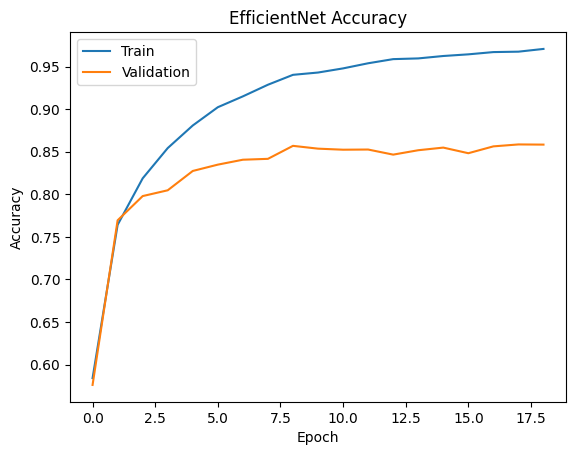

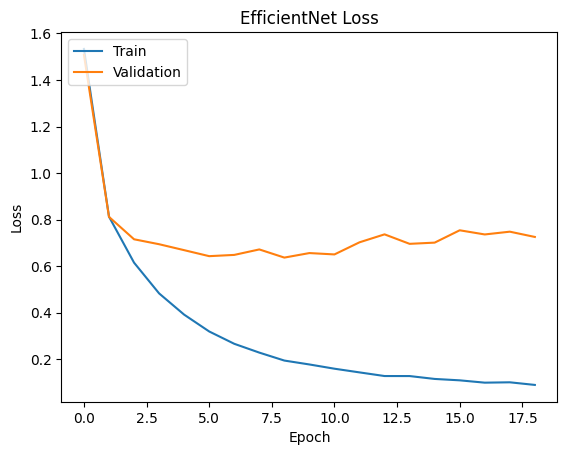

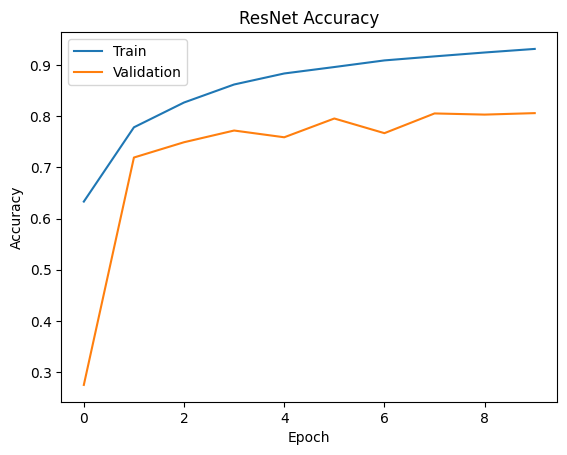

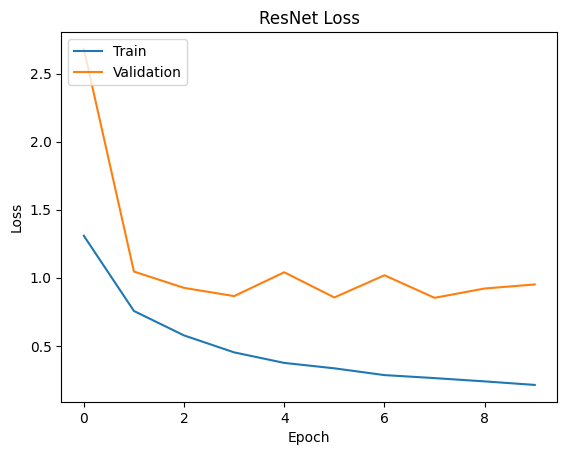

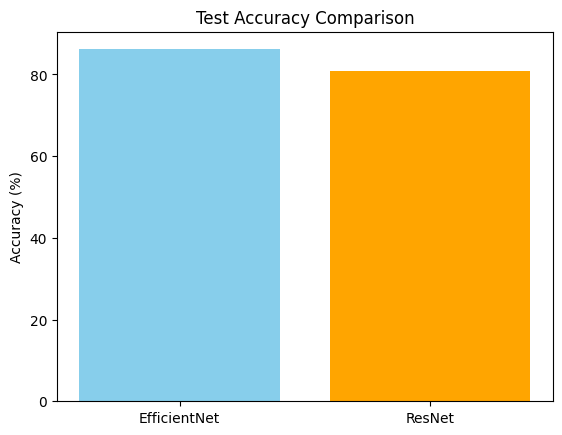

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot training & validation accuracy values
def plot_accuracy(history, model_name):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot training & validation loss values
def plot_loss(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot EfficientNet graphs
plot_accuracy(history_efficientnet, "EfficientNet")
plot_loss(history_efficientnet, "EfficientNet")

# Plot ResNet graphs
plot_accuracy(history_resnet, "ResNet")
plot_loss(history_resnet, "ResNet")


# Compare test accuracies
models = ['EfficientNet', 'ResNet']
accuracies = [efficientnet_eval[1]*100, resnet_eval[1]*100]

# Custom colors
colors = ['#87CEEB', '#FFA500']  

plt.bar(models, accuracies, color=colors)
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.show()


152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step


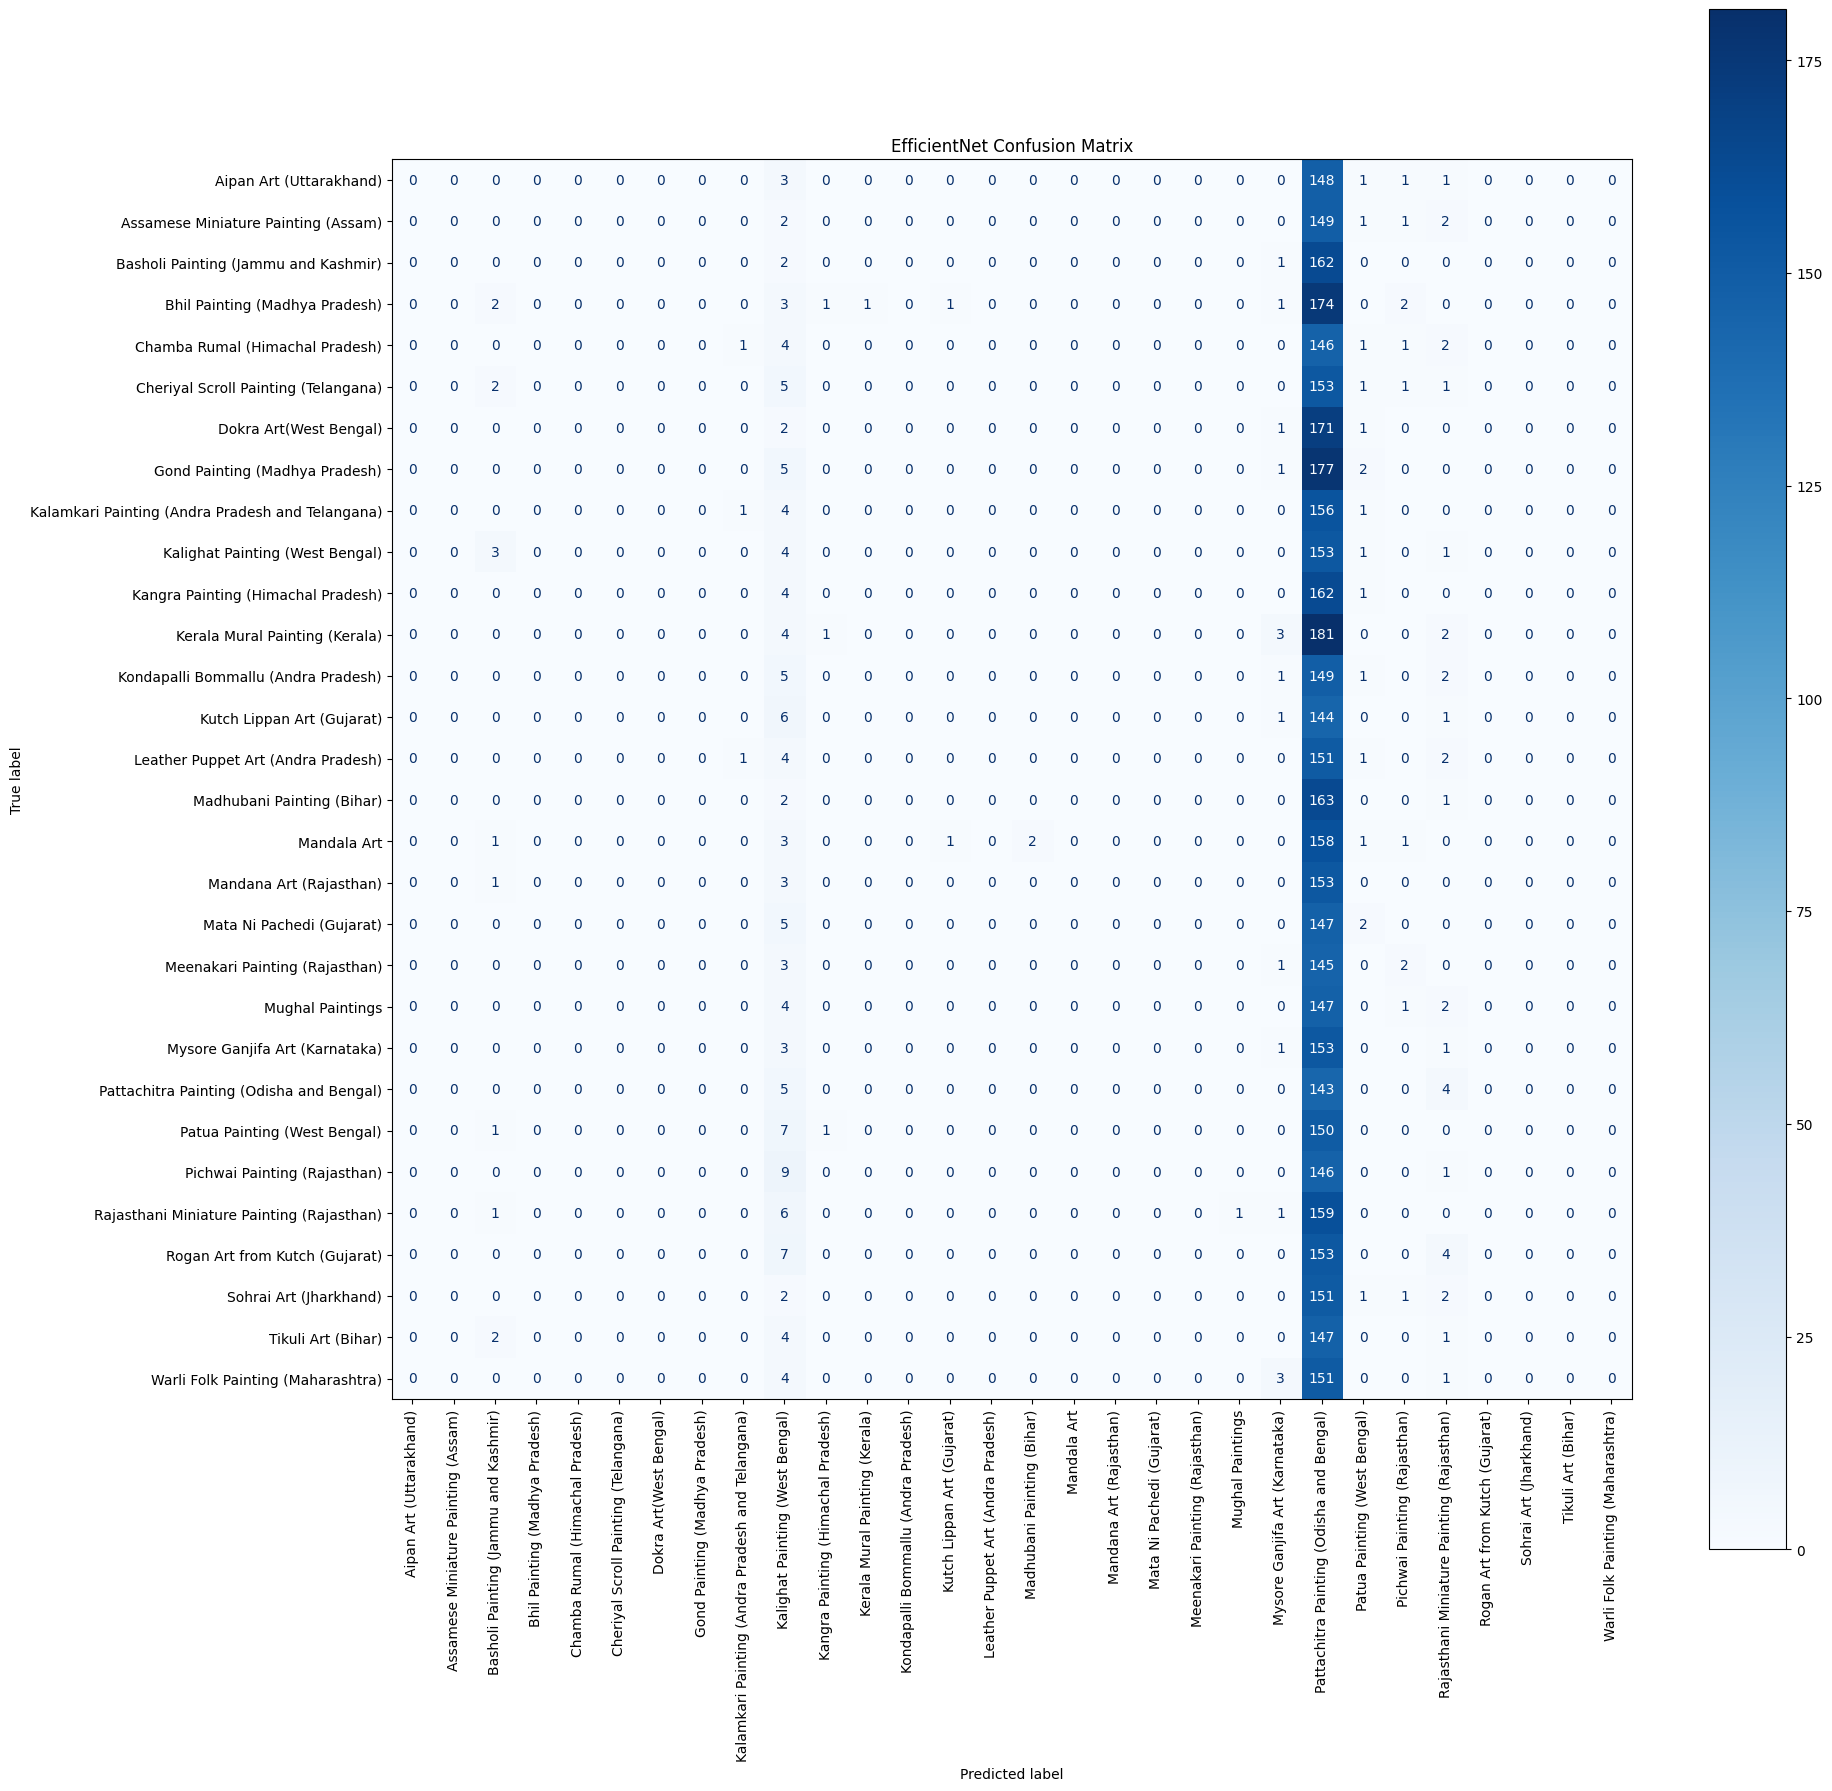

152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step


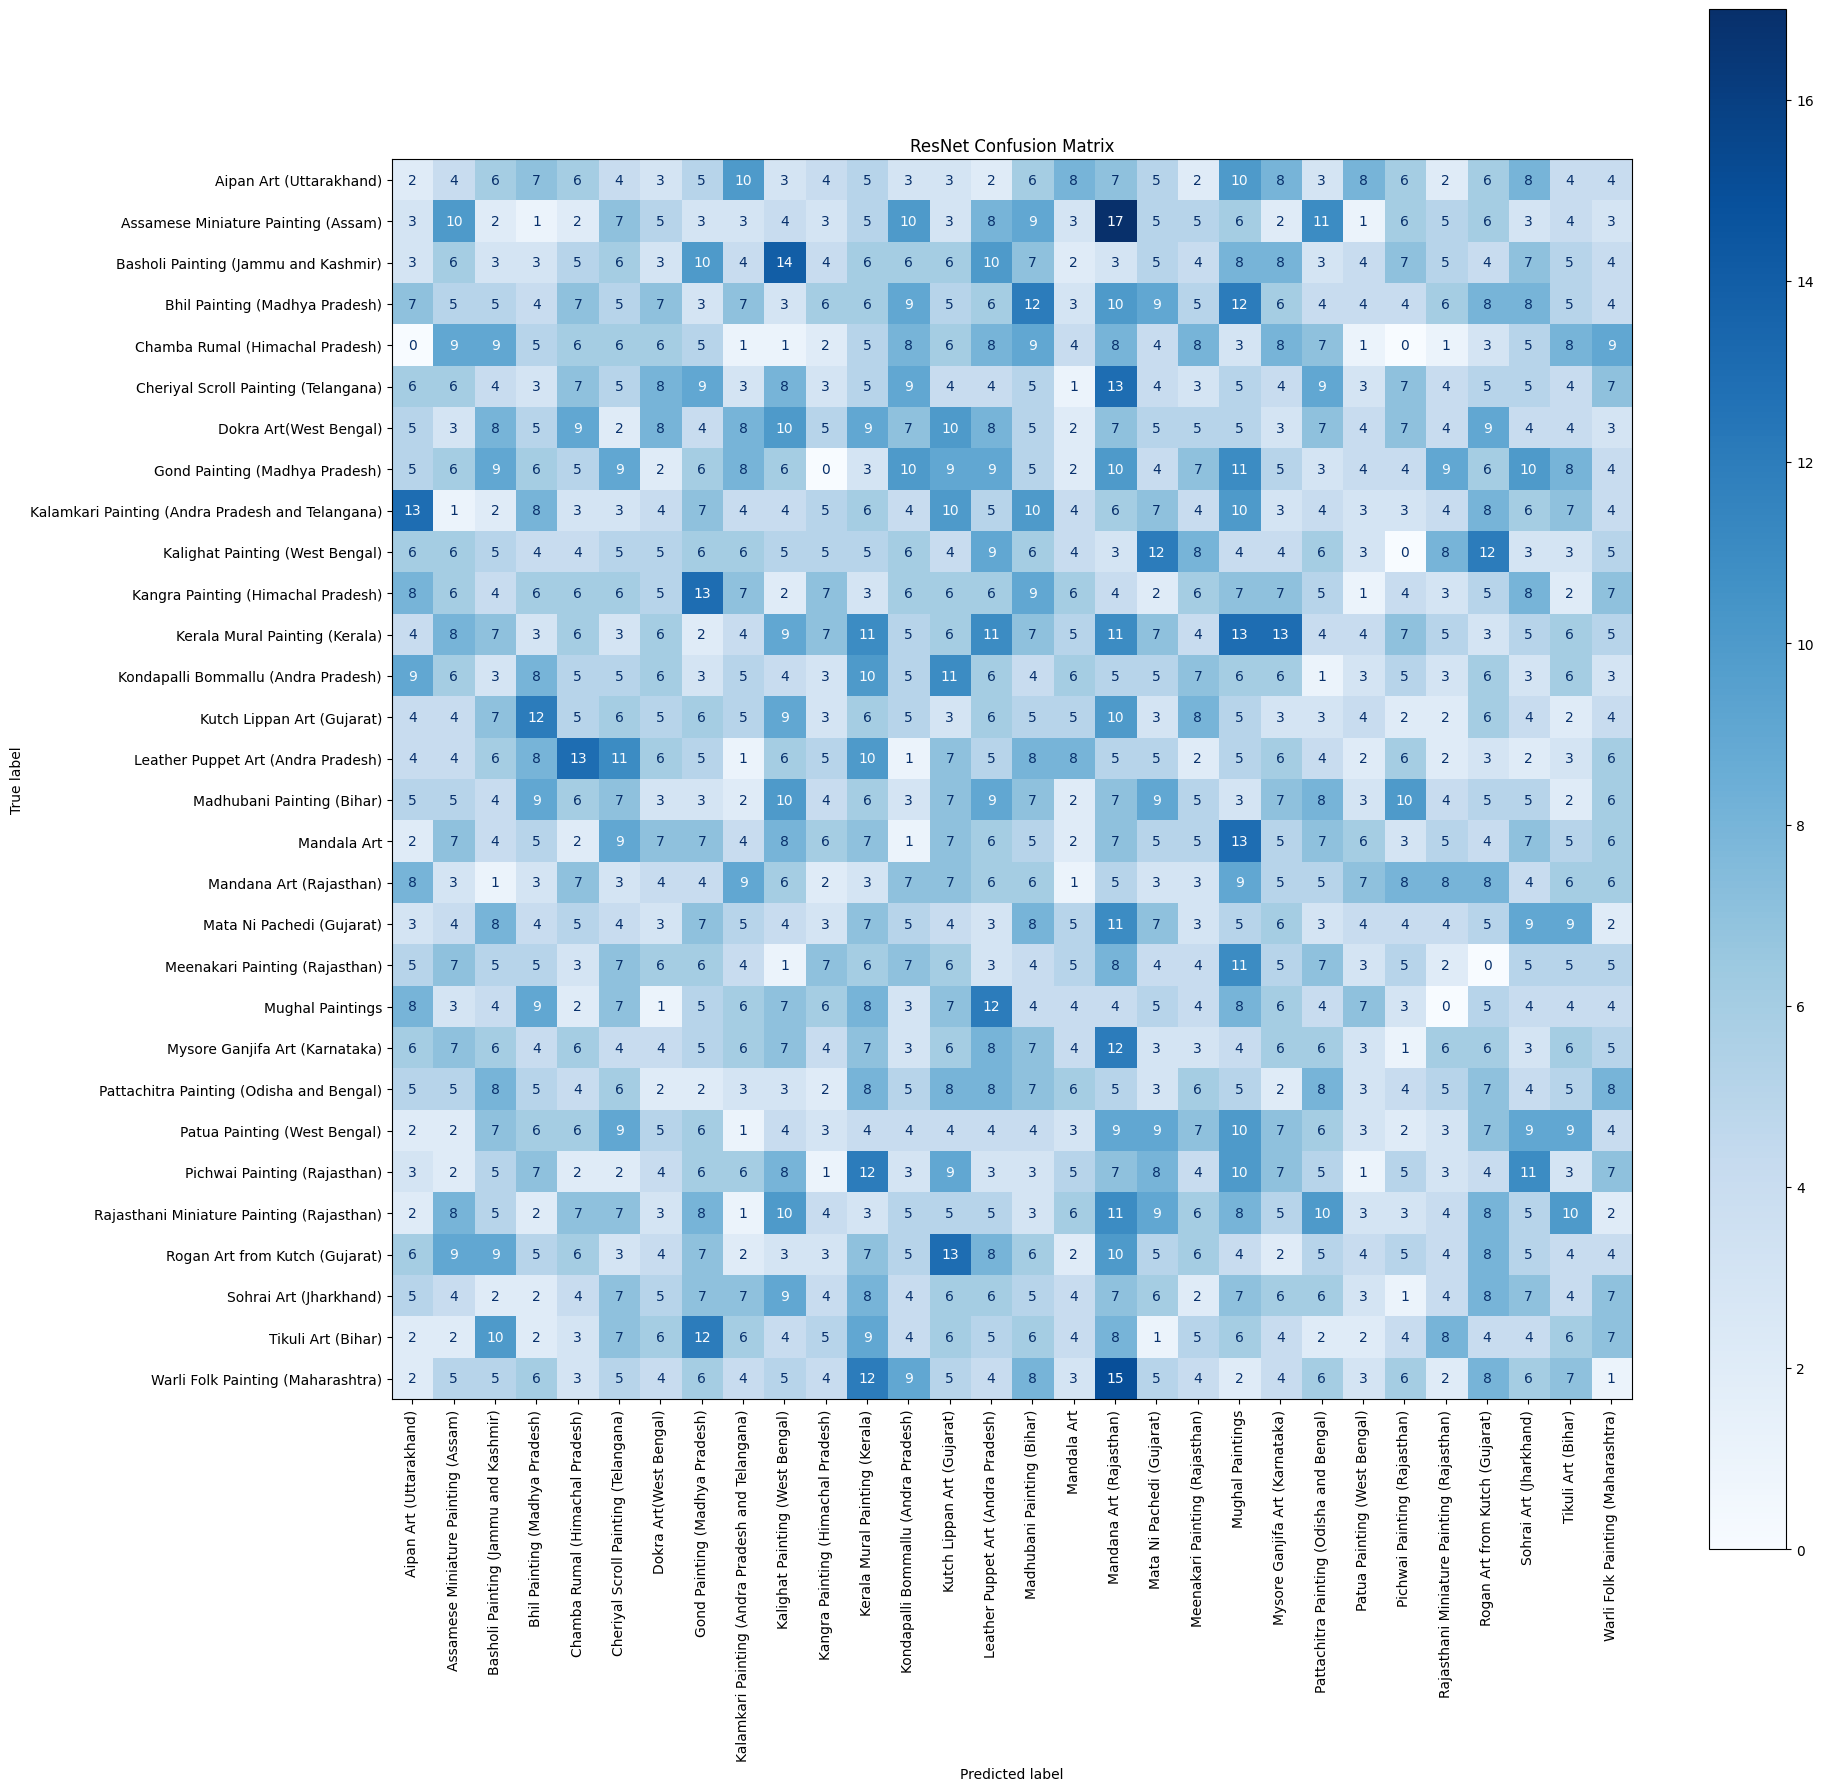

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot confusion matrix with improved readability
def plot_confusion_matrix_improved(model, generator, model_name):
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(generator.classes, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(generator.class_indices.keys()))
    
    fig, ax = plt.subplots(figsize=(20, 20))  # Increase figure size
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')  # Rotate x-axis labels
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Improved plots for EfficientNet
plot_confusion_matrix_improved(model_efficientnet, test_generator, "EfficientNet")

# Improved plots for ResNet
plot_confusion_matrix_improved(model_resnet, test_generator, "ResNet")


152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step


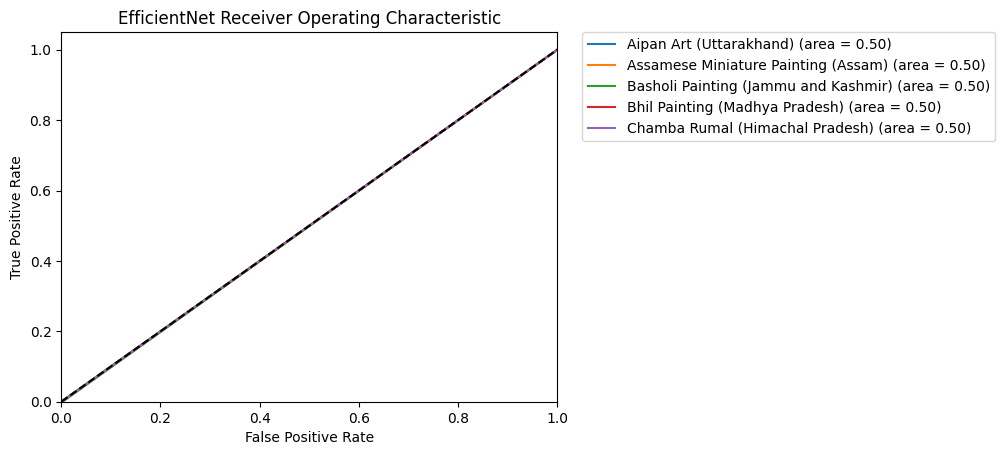

152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step


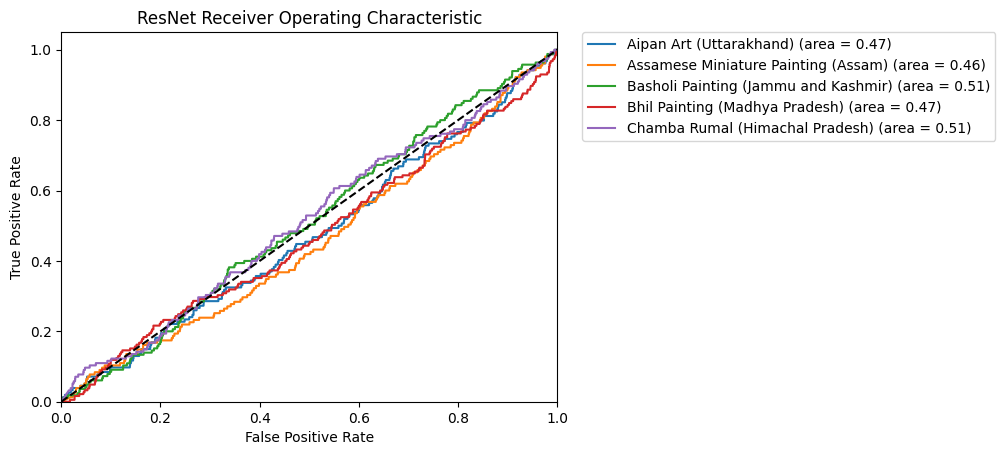

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to plot ROC Curve for selected classes
def plot_roc_selected_classes(model, generator, model_name, class_names, selected_classes):
    y_true = generator.classes
    y_pred = model.predict(generator)
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure()
    for i in selected_classes:
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

# Selected classes to plot
selected_classes = [0, 1, 2, 3, 4]  # Change these indices as per your preference

# Plot ROC Curve for selected classes in EfficientNet
plot_roc_selected_classes(model_efficientnet, test_generator, "EfficientNet", class_names, selected_classes)

# Plot ROC Curve for selected classes in ResNet
plot_roc_selected_classes(model_resnet, test_generator, "ResNet", class_names, selected_classes)
